<a href="https://colab.research.google.com/github/jaeohshin/keras/blob/main/tutorial_5_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here we use Convnet to distinguish between dogs and cats from kaggle data.


In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jaeohshin","key":"b06496892a173235f5af3b31663da13d"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats --force

100% 810M/812M [00:22<00:00, 42.6MB/s]
100% 812M/812M [00:22<00:00, 37.9MB/s]


In [4]:
!unzip -qq dogs-vs-cats.zip

In [5]:
!unzip -qq train.zip

In [6]:
#Separate the train data into three categories: train, validation, and test
# Each has 1000, 500, and 1000 images.

import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

Building a model

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [9]:
model.compile(loss = "binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [10]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [11]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("label batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
label batch shape: (32,)


In [12]:
callbacks = [
    keras.callbacks.ModelCheckpoint (
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]



In [ ]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 18s 95ms/step - loss: 0.6965 - accuracy: 0.4955 - val_loss: 0.6927 - val_accuracy: 0.5170
Epoch 2/30
63/63 [==============================] - 4s 62ms/step - loss: 0.6938 - accuracy: 0.5135 - val_loss: 0.6909 - val_accuracy: 0.5070
Epoch 3/30
63/63 [==============================] - 6s 84ms/step - loss: 0.6964 - accuracy: 0.5580 - val_loss: 0.9158 - val_accuracy: 0.5000
Epoch 4/30
63/63 [==============================] - 4s 61ms/step - loss: 0.6511 - accuracy: 0.6200 - val_loss: 0.6315 - val_accuracy: 0.6390
Epoch 5/30
63/63 [==============================] - 4s 62ms/step - loss: 0.6163 - accuracy: 0.6440 - val_loss: 0.6300 - val_accuracy: 0.6490
Epoch 6/30
63/63 [==============================] - 5s 78ms/step - loss: 0.5926 - accuracy: 0.6885 - val_loss: 0.7208 - val_accuracy: 0.6060
Epoch 7/30
63/63 [==============================] - 4s 66ms/step - loss: 0.5549 - accuracy: 0.7170 - val_loss: 0.5872 - val_accuracy: 0.6770
Epoch 8/30
6

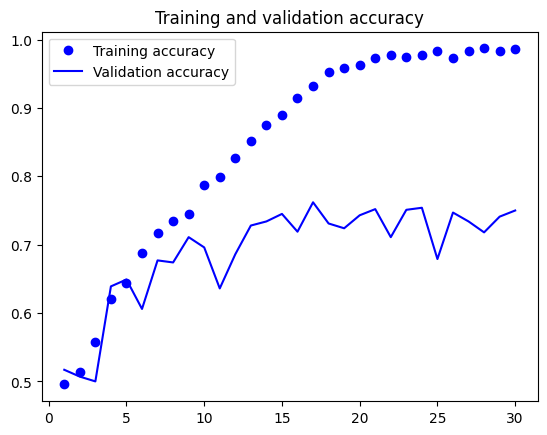

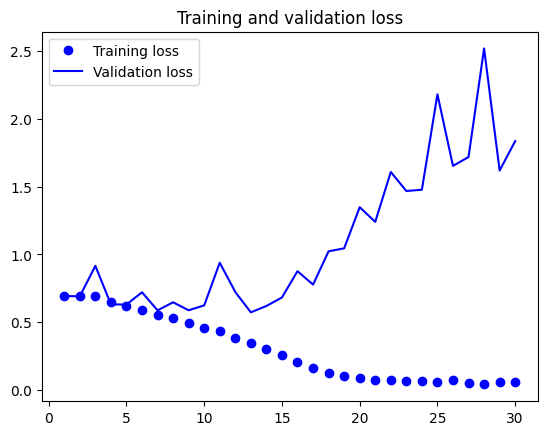

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc: .3f}")

63/63 [==============================] - 2s 33ms/step - loss: 0.6338 - accuracy: 0.7085
Test accuracy:  0.709


In [ ]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## The accuracy is about 68%. We need to use several techniques to improve it below.

1.   Overfitting: Caused by limited training data. We will use data augmentation, i.e., generating more traning data by randomly trasforming the original data.

2.   List item





In [13]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

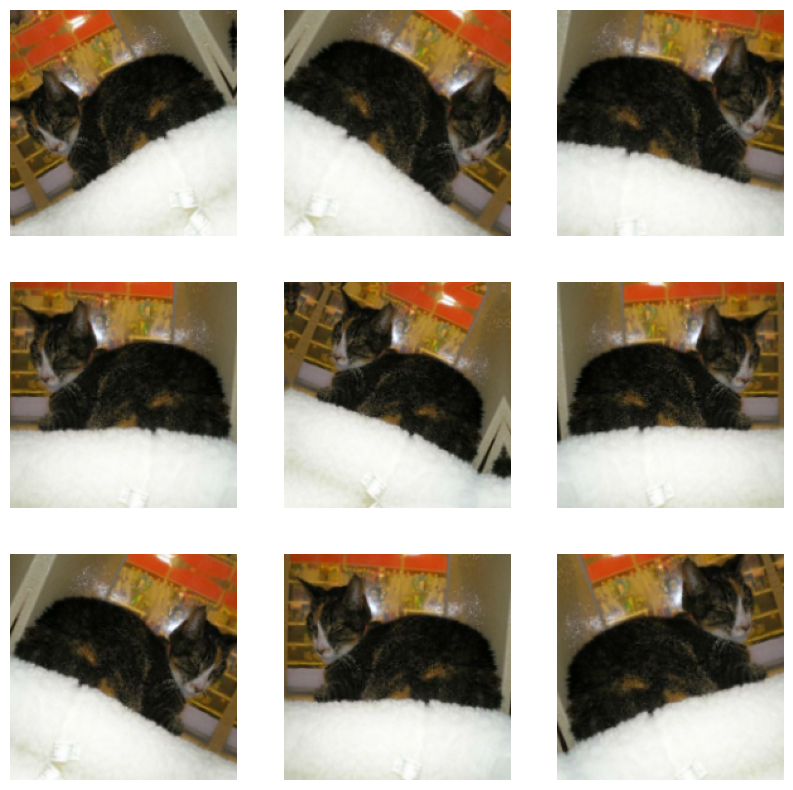

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

#New convnet with data augmentation and drop out

In [15]:
from tensorflow import keras

inputs = keras.Input(shape=(180, 180, 3))

# data augmentation
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

## Apply dropout here.
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [16]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=70,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/70
63/63 [==============================] - 19s 91ms/step - loss: 0.7061 - accuracy: 0.5000 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 2/70
63/63 [==============================] - 6s 88ms/step - loss: 0.6938 - accuracy: 0.5165 - val_loss: 0.6923 - val_accuracy: 0.5270
Epoch 3/70
63/63 [==============================] - 4s 65ms/step - loss: 0.6914 - accuracy: 0.5500 - val_loss: 0.6981 - val_accuracy: 0.5130
Epoch 4/70
63/63 [==============================] - 4s 63ms/step - loss: 0.6859 - accuracy: 0.5645 - val_loss: 0.6678 - val_accuracy: 0.5540
Epoch 5/70
63/63 [==============================] - 5s 81ms/step - loss: 0.6505 - accuracy: 0.6250 - val_loss: 0.6874 - val_accuracy: 0.6220
Epoch 6/70
63/63 [==============================] - 4s 64ms/step - loss: 0.6335 - accuracy: 0.6485 - val_loss: 0.7304 - val_accuracy: 0.5830
Epoch 7/70
63/63 [==============================] - 4s 64ms/step - loss: 0.6136 - accuracy: 0.6750 - val_loss: 0.5828 - val_accuracy: 0.6820
Epoch 8/70
6

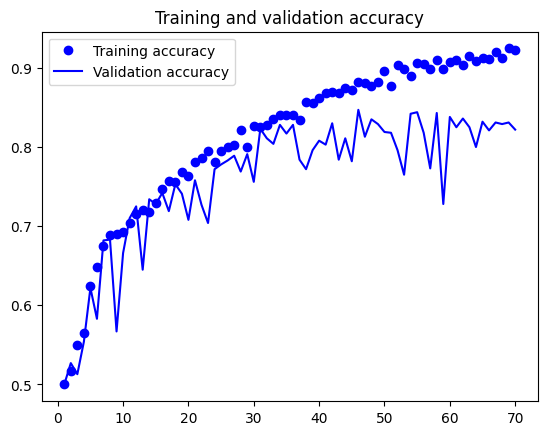

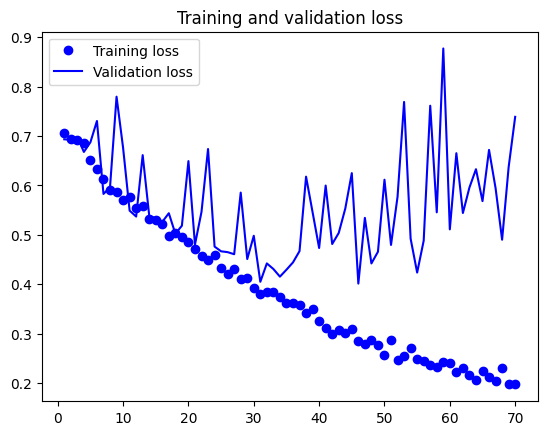

In [17]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [18]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 2s 33ms/step - loss: 0.4576 - accuracy: 0.8285
Test accuracy: 0.828


#Saved convnet_from_scratch_with_augmentation.keras 바탕화면

##Use a pretrained model

In [19]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 2s 0us/step


In [20]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [21]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 22ms/step


In [22]:
train_features.shape

(2000, 5, 5, 512)

In [23]:
test_features.shape

(2000, 5, 5, 512)

In [24]:
val_features.shape

(1000, 5, 5, 512)

In [25]:
inputs = keras.Input (shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 2s 11ms/step - loss: 15.9630 - accuracy: 0.9220 - val_loss: 2.8042 - val_accuracy: 0.9710
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 3.2065 - accuracy: 0.9765 - val_loss: 3.6131 - val_accuracy: 0.9720
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 2.2826 - accuracy: 0.9830 - val_loss: 3.5861 - val_accuracy: 0.9760
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 0.8209 - accuracy: 0.9935 - val_loss: 6.2490 - val_accuracy: 0.9620
Epoch 5/20
63/63 [==============================] - 0s 5ms/step - loss: 1.5053 - accuracy: 0.9905 - val_loss: 4.0620 - val_accuracy: 0.9760
Epoch 6/20
63/63 [==============================] - 0s 5ms/step - loss: 0.9578 - accuracy: 0.9940 - val_loss: 6.0875 - val_accuracy: 0.9670
Epoch 7/20
63/63 [==============================] - 0s 5ms/step - loss: 0.8108 - accuracy: 0.9955 - val_loss: 3.8606 - val_accuracy: 0.9790
Epoch 8/20
63/63 [

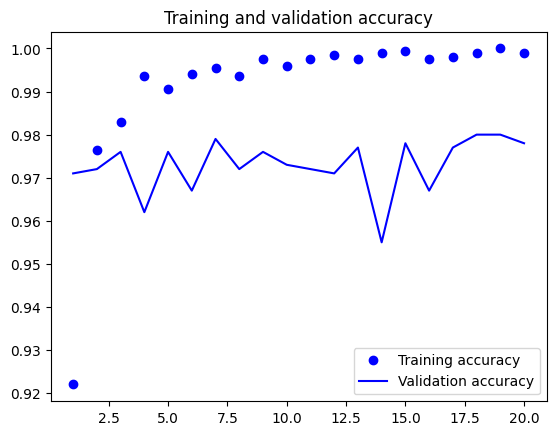

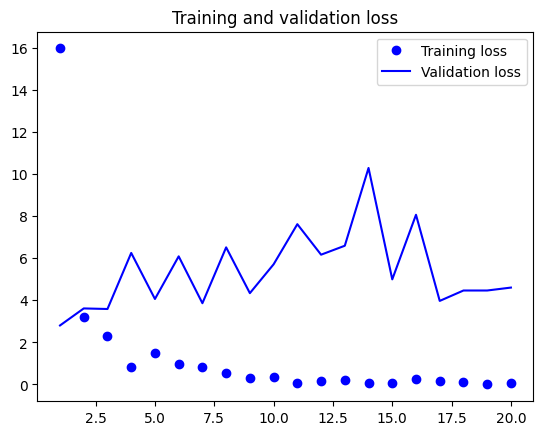

In [26]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#Feature extraction together with data augmentation

In [27]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False, #not include the densely connected network
)
conv_base.trainable = False

In [28]:
conv_base.trainable=True
print("number of trainable variables", len(conv_base.trainable_weights))

conv_base.trainable=False
print("number of trainable variables", len(conv_base.trainable_weights))

number of trainable variables 26
number of trainable variables 0


In [29]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


In [30]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss" )
]

In [31]:
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 11s 156ms/step - loss: 18.4078 - accuracy: 0.8995 - val_loss: 10.1166 - val_accuracy: 0.9420
Epoch 2/50
63/63 [==============================] - 10s 159ms/step - loss: 7.0650 - accuracy: 0.9475 - val_loss: 6.7343 - val_accuracy: 0.9620
Epoch 3/50
63/63 [==============================] - 11s 164ms/step - loss: 7.0709 - accuracy: 0.9530 - val_loss: 3.5782 - val_accuracy: 0.9770
Epoch 4/50
63/63 [==============================] - 10s 154ms/step - loss: 5.5621 - accuracy: 0.9650 - val_loss: 9.8754 - val_accuracy: 0.9530
Epoch 5/50
63/63 [==============================] - 10s 156ms/step - loss: 5.5428 - accuracy: 0.9530 - val_loss: 3.8051 - val_accuracy: 0.9740
Epoch 6/50
63/63 [==============================] - 10s 152ms/step - loss: 4.4490 - accuracy: 0.9620 - val_loss: 5.0616 - val_accuracy: 0.9760
Epoch 7/50
63/63 [==============================] - 10s 155ms/step - loss: 3.6736 - accuracy: 0.9670 - val_loss: 4.4763 - val_accuracy: 0.97

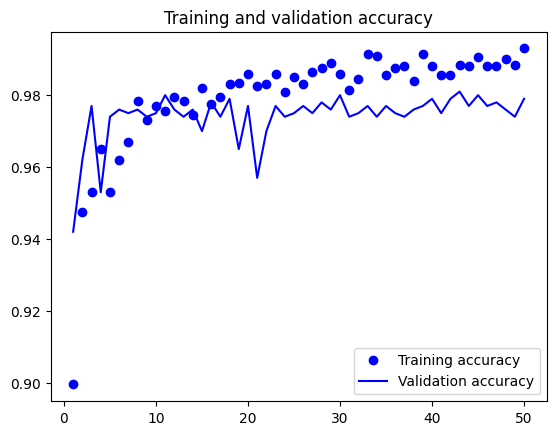

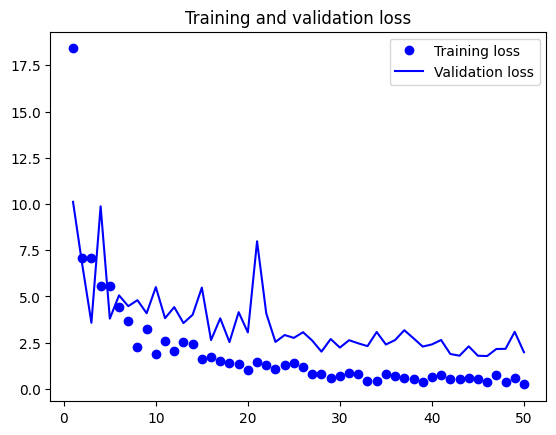

In [32]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [33]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc: .3f}")

63/63 [==============================] - 6s 94ms/step - loss: 2.4657 - accuracy: 0.9750
Test accuracy:  0.975
